In [1]:
import scipy.io
import matplotlib.pyplot as plt
from scipy.special import expit
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [2]:
mat = scipy.io.loadmat('ejemplo_regresion.mat')
x = mat.get('x')
y = mat.get('y')
t = mat.get('t')
consumo_mat = scipy.io.loadmat('consumoDB.mat')
hrsignal_mat = scipy.io.loadmat('HRsignal.mat')

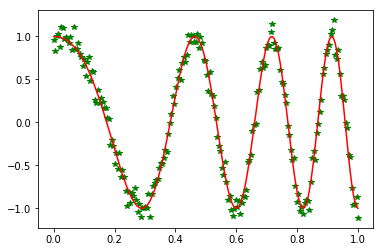

In [3]:
plt.figure
plt.plot(x, t, '*g')
plt.plot(x, y, '-r')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


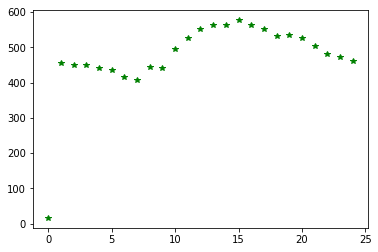

In [4]:
consumo_x = consumo_mat.get('x')
consumo_t = consumo_mat.get('t')
std_consumo_x = preprocessing.scale(consumo_x)
std_consumo_t = preprocessing.scale(consumo_t)
plt.figure
plt.plot(consumo_x, consumo_t, '*g')

In [307]:
def expFunction(x, miu, s):
    return np.exp(-np.power((x - miu), 2)/(2*s*s))

def BFunction(xi, M, Fbase, x_mean):
    phiXn = np.zeros(M)
    if(Fbase == 'poly'):
        idP = np.linspace(0, M - 1, M)
        phiXn = np.power(xi, idP)
    if(Fbase == 'exp'):
        miuj = np.full(phiXn.shape, x_mean)
        idP = np.linspace(0, M - 1, M)
        s = 5
        phiXn = expFunction(xi, idP, s)
    if(Fbase == 'sigmod'):
        s = 2
        idP = np.linspace(0, M - 1, M)
        a = (xi - idP) / s
        phiXn = expit(a)
    return phiXn


def MBFunction(x_vect, M, Fbase):
    N = np.size(x_vect)
    PHIX = np.zeros([N,M])
    for i in range(0,N):
        PHIX[i,:] = BFunction(x_vect[i],M,Fbase, np.mean(x_vect))
    return PHIX

def calcYEst(mPHIX, t):
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.pinv(mPHIXT.dot(mPHIX))
    w_ml = mPHIXT_pw2_inv.dot(mPHIXT).dot(t)
    return mPHIX.dot(w_ml)

def calcYEstReg(mPHIX, t):
    L = np.exp(-20)
    mPHIXT = mPHIX.T
    mPHIXT_pw2_inv = np.linalg.inv(mPHIXT.dot(mPHIX) + L*np.eye(M))
    w_ml = mPHIXT_pw2_inv.dot(mPHIXT.dot(t))
    return mPHIX.dot(w_ml)


In [193]:
M=24
N = x.shape[0]
mPHIX = MBFunction(x, M, 'poly')
yEst = calcYEst(mPHIX, t)

MSE =  0.002828038813040679


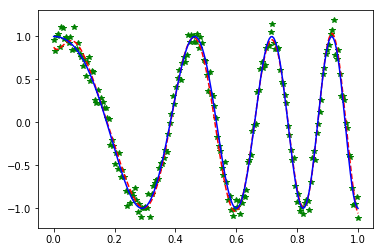

In [194]:
plt.plot(x, t, '*g')
plt.plot(x, yEst, '--r')
plt.plot(x, y, '-b')
diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [287]:
M=19
N = x.shape[0]
mPHIX = MBFunction(x, M, 'sigmod')
yEst = calcYEst(mPHIX, t)

MSE =  0.3997875095110329


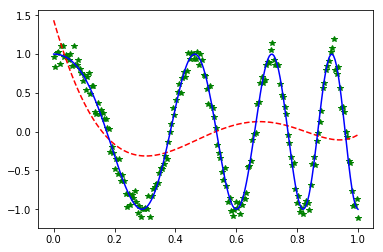

In [288]:
plt.plot(x, t, '*g')
plt.plot(x, yEst, '--r')
plt.plot(x, y, '-b')
diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [305]:
M=30
N = x.shape[0]
mPHIX = MBFunction(x, M, 'exp')
yEst = calcYEst(mPHIX, t)

MSE =  0.3963333001163548


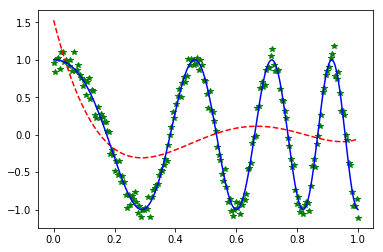

In [306]:
plt.plot(x, t, '*g')
plt.plot(x, yEst, '--r')
plt.plot(x, y, '-b')
diff = y - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [283]:
M=26
N = consumo_x.shape[0]
std_consumo_x = preprocessing.scale(consumo_x)
std_consumo_t = preprocessing.scale(consumo_t)
mPHIX = MBFunction(std_consumo_x, M, 'poly')
yEst = calcYEst(mPHIX, std_consumo_t)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


MSE =  0.002535025875531407


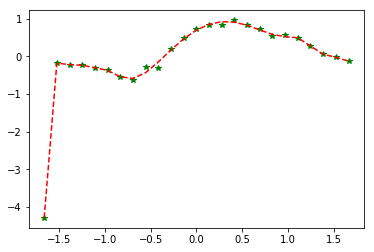

In [284]:
plt.plot(std_consumo_x, std_consumo_t, '*g')
plt.plot(std_consumo_x, yEst, '--r')
diff = std_consumo_t - yEst
error = 1. / N * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [285]:
M=19
mPHIX = MBFunction(consumo_x, M, 'sigmod')
yEst = calcYEst(mPHIX, consumo_t)

MSE =  181.68923796474738


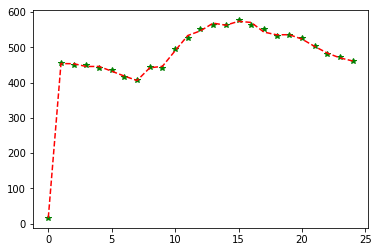

In [286]:
plt.plot(consumo_x, consumo_t, '*g')
plt.plot(consumo_x, yEst, '--r')

diff = consumo_t - yEst
error = 0.5 * diff.T.dot(diff)
print("MSE = ", np.squeeze(error))

In [384]:
M=20
mPHIX = MBFunction(consumo_x, M, 'exp')
yEst = calcYEst(mPHIX, consumo_t)

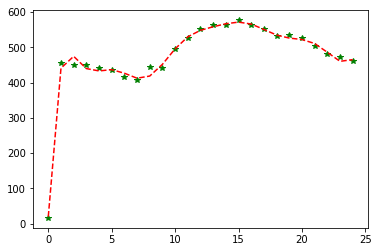

In [385]:
plt.plot(consumo_x, consumo_t, '*g')
plt.plot(consumo_x, yEst, '--r')

(50, 1)

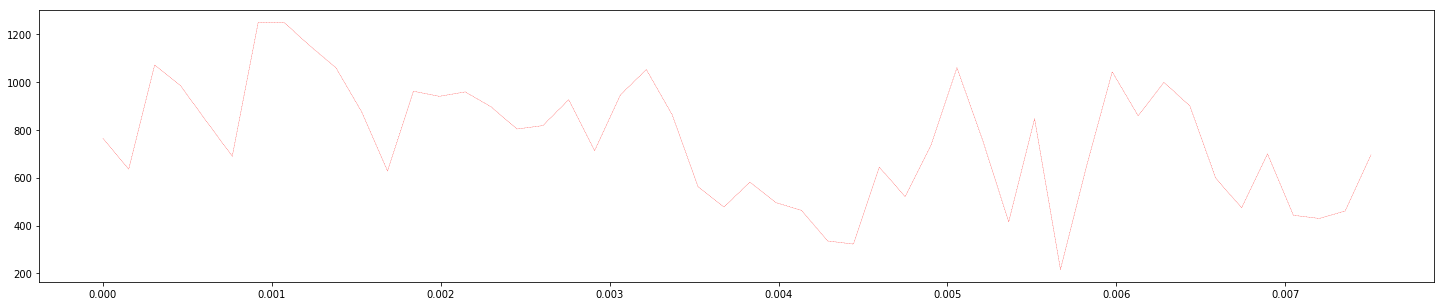

In [618]:
hrsignal_mat = scipy.io.loadmat('HRsignal.mat')
hr_t = hrsignal_mat.get('HR')[:50]
hr_x = hrsignal_mat.get('x').T[:50]

std_x = preprocessing.scale(hr_x)
std_t = preprocessing.scale(hr_t)

plt.figure(figsize=(25,5))
plt.plot(hr_x, hr_t,  linestyle='--' , linewidth=0.3, color='red')
hr_t.shape

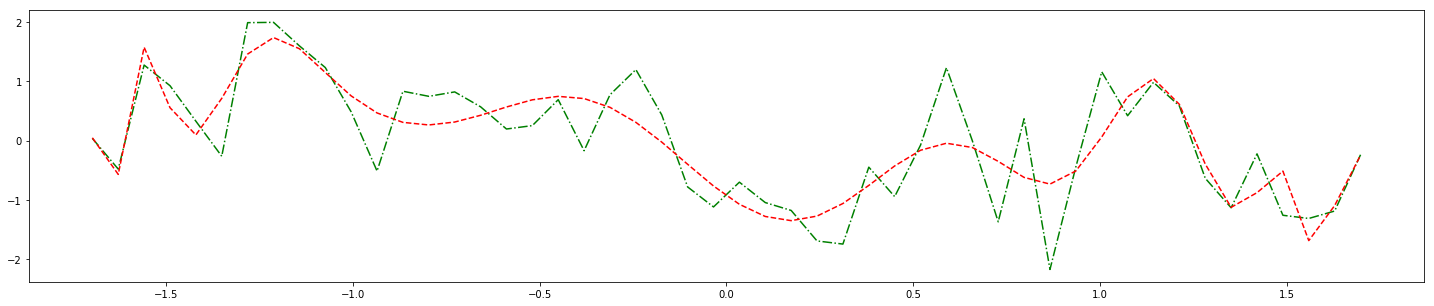

In [626]:
M=25
mPHIX = MBFunction(std_x, M, 'poly')
yEst = calcYEst(mPHIX, std_t)
plt.figure(figsize=(25,5))
plt.plot(std_x,std_t, '-.g')
plt.plot(std_x, yEst, '--r')

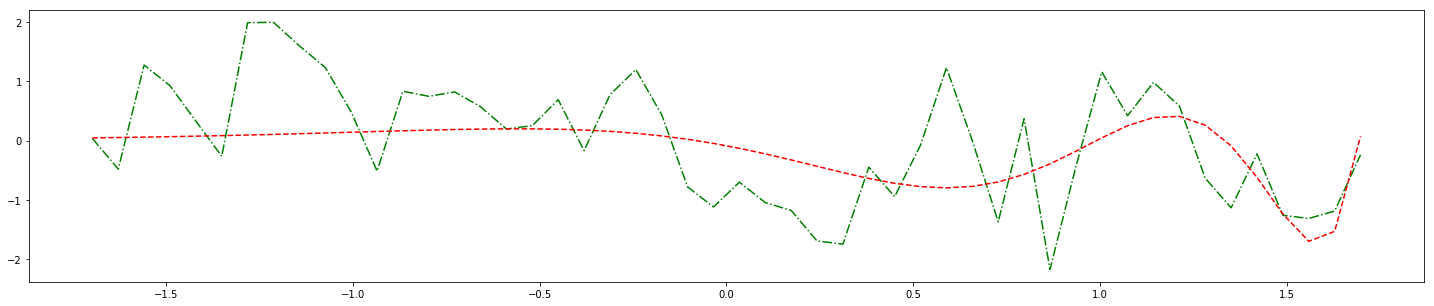

In [636]:
M=40
mPHIX = MBFunction(std_x, M, 'sigmod')
yEst = calcYEst(mPHIX, std_t)
plt.figure(figsize=(25,5))
plt.plot(std_x,std_t, '-.g')
plt.plot(std_x, yEst, '--r')